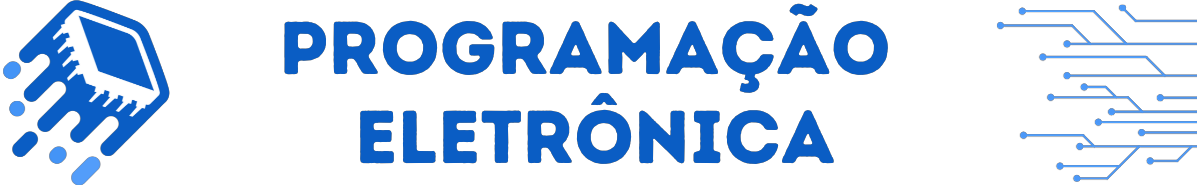

<a href="https://colab.research.google.com/github/programacao-eletronica/dsp_notebooks/blob/master/Gerador%20de%20buffer%20de%20sinais/Gerador%20de%20buffer%20de%20sinais.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
<a href="https://github.com/programacao-eletronica/dsp_notebooks/blob/master/Gerador%20de%20buffer%20de%20sinais/Gerador%20de%20buffer%20de%20sinais.ipynb" target="_parent"><img align="left" src="https://img.shields.io/badge/GitHub-Open%20source-green?logo=github&style=plastic.svg"></a>

# Gerador de buffer de sinais 🤓

Material complementar do curso de [Processamento Digital de Sinais: da amostragem à FFT](https://programacaoeletronica.wordpress.com/cursos-online/)!

** **

Usabilidade: vá até a seção **Geração de buffer de sinal simulado** e altere os parâmetros desejados de frequências, amplitude e nome do buffer a ser gerado. Em caso de dúvidas, consulte [ESTE POST](https://programacaoeletronica.wordpress.com/2024/01/02/jupyter-notebook-gerador-de-buffer-de-senoides-em-c/) do blog.

# Definição de funções

In [43]:
# @title Preparação do ambiente

# Limpa todas as variáveis de RAM do ambiente
%reset -f

# Import das libs necessárias
import numpy as np
from numpy.fft import fft
from matplotlib import pyplot as plt
import scipy

In [44]:
# @title Geração de sinais

# Geração de senóides
def generate_sinusoid(dur=1, amp=1, freq=1, phase=0, Fs=100):
    """Generation of sinusoid

    Args:
        dur: Duration (in seconds) of sinusoid (Default value = 1)
        amp: Amplitude of sinusoid (Default value = 1)
        freq: Frequency (in Hertz) of sinusoid (Default value = 1)
        phase: Phase (relative to interval [-360, 360])
        Fs: Sampling rate (in samples per second) (Default value = 100)

    Returns:
        x: Signal
        t: Time axis (in seconds)
    """
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    x = amp * np.sin(2 * np.pi * (freq * t + phase/(360)))
    return x, t

In [45]:
# @title Plotagem de dados

# Plotagem de sinal no domínio do tempo
def plot_signal_time(t, x, figsize=(12.5, 4)):
    """Plotting three signals

    Args:
        t: Time axis
        x: Signal
    """
    plt.figure(figsize=figsize)
    plt.plot(t, x)
    plt.title('Sinal no domínio do tempo')
    plt.xlabel('t')
    plt.ylabel('x[n]')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [46]:
# @title Salvando buffer como arquivo

def save_buff_to_header(buff, headerName, sampleRate, dtype='float', bits=0):
    if dtype != 'float':
        # Normalizing by the maximum value
        max_value = np.max(np.abs(buff))
        normalized_buffer = (buff / max_value)

        # Converting to the specified data type and range
        if dtype == 'uint8_t':
            normalized_buffer = np.interp(normalized_buffer, [-1, 1], [0, 255])
            int_buffer = normalized_buffer.astype(np.uint8)
        elif dtype == 'uint16_t':
            normalized_buffer = np.interp(normalized_buffer, [-1, 1], [0, 65535])
            int_buffer = normalized_buffer.astype(np.uint16)
        elif dtype == 'uint32_t':
            normalized_buffer = np.interp(normalized_buffer, [-1, 1], [0, 4294967295])
            int_buffer = normalized_buffer.astype(np.uint32)
        elif dtype == 'bits':
            if bits == 0:
                raise ValueError("Deve ser configurado o numero de bits.")

            normalized_buffer = np.interp(normalized_buffer, [-1, 1], [0, 2**bits-1])
            if bits > 16:
                dtype = 'uint32_t'
            elif bits > 8:
                dtype = 'uint16_t'
            else:
                dtype = 'uint8_t'
            int_buffer = normalized_buffer.astype(np.uint32)
        else:
            raise ValueError("Tipo de dados não suportado.")
    else:
        int_buffer = buff

    buffer_list = int_buffer.tolist()

    # Saving as a text file
    with open('buffer.txt', 'w') as file:
        file.write("""/*******************************************************************************************************/
/**
*   @file         """ + headerName + """.h
*   @addtogroup   PROG_ELET_BUFFS
*   @brief        Buffer constante
*   @author       Gerador automatico do Programacao Eletronica
*   @details      Frequencia de amostragem: """ + str(sampleRate) + """ Hz.""")
        if bits > 0:
            file.write(""" Sinal simulando AD de """ + str(bits) + """ bits.""")
        file.write("""
*
*   @copyright    Wenderson Oliveira - https://programacaoeletronica.wordpress.com
*   @{
********************************************************************************************************/

""")
        file.write('#ifndef BUFFER_' + headerName.upper() + '_H_\n')
        file.write('#define BUFFER_' + headerName.upper() + '_H_\n\n')
        file.write('const ' + dtype + ' buffer_' + headerName.lower() + '['+ str(len(normalized_buffer)) + '] = {\n    ')

        # Calculate the maximum width of values for formatting
        max_width = max(len(str(value)) for value in buffer_list)

        # Writing data in lines of 16 elements
        for i, value in enumerate(buffer_list):
            value_str = f'{value:>{max_width}}, '
            file.write(value_str)

            # Adds a line break after every 16 elements
            if (i + 1) % 16 == 0:
                file.write('\n    ')
            else:
                file.write(' ')

        file.write('\n};\n\n')
        file.write("""#endif  /*  BUFFER_""" + headerName.upper() + """_H   */

/** @} FILE */""")

    # Renaming to .h
    import os
    os.rename('buffer.txt', headerName + '.h')

# Geração de buffer de sinal simulado

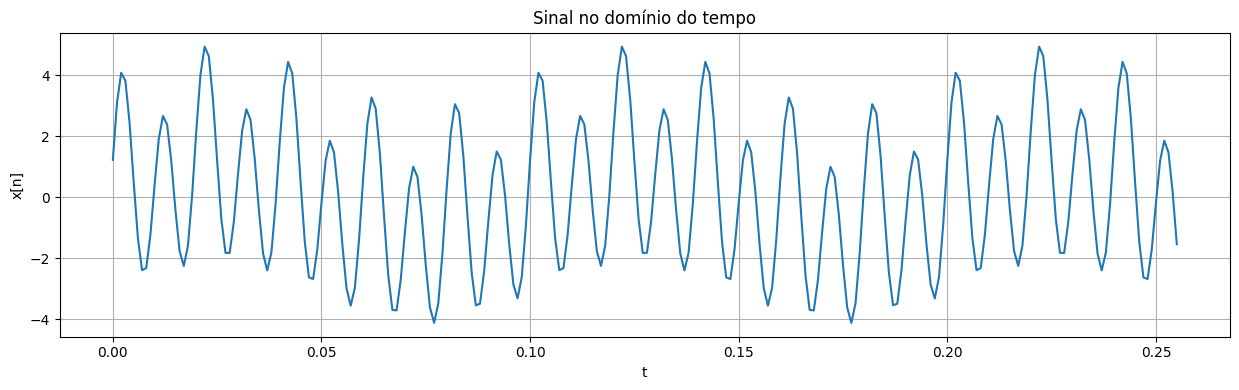

In [47]:
# @title Buffer exemplo

sample_rate     = 1000    # taxa de amostragem em Hz
numberOfSamples = 256     # número de amostras

####################################################################################################

duration = numberOfSamples / sample_rate

sin1, t = generate_sinusoid(dur=duration, amp=1,    freq=50,  phase=45,  Fs=sample_rate)
sin2, t = generate_sinusoid(dur=duration, amp=3,    freq=100, phase=10,  Fs=sample_rate)
sin3, t = generate_sinusoid(dur=duration, amp=1,    freq=10,  phase=0,   Fs=sample_rate)

signal = sin1 + sin2 + sin3

# Plot no tempo (amostras)
plot_signal_time(t, signal)

save_buff_to_header(signal, "simulated_signal_int16", sample_rate, dtype='uint16_t')
save_buff_to_header(signal, "simulated_signal_ad12b", sample_rate, dtype='bits', bits=12)

Referências:


1. HAYES, Monson H. **Schaum's outline of theory and problems of digital signal processing**. Estados Unidos: McGraw-Hill, 1999. 436 p

** **

image.png

Este notebook é licenciado sob os termos da [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/).